<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/dampfer_tightness_projection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
life_time_final = 60 * 60 * 24 * 30 * 12 * 15
time_step = 300
Pinitial = 2000
Pambient = 1000
V = 0.001
Pcritic = 1500
Qinitial_vals = np.arange(1.1E-9, 1E-8, 1.1E-9)
df_list = []

for Qinitial in Qinitial_vals[:1]:
    Premain_1 = Pinitial - (Qinitial * time_step / V)
    mask_1 = Premain_1 > Pcritic
    Q_list_1 = (Qinitial * ((Premain_1[mask_1] * Premain_1[mask_1]) - (Pambient * Pambient)) / ((Pinitial * Pinitial) - (Pambient * Pambient)))
    P_remain_1 = Premain_1[mask_1]

    time_actual = np.arange(time_step, life_time_final, time_step)
    Premain_list = Premain_1 - (Q_list_1 * time_actual / V)
    mask = Premain_list > Pcritic
    Q_list = (Q_list_1 * ((Premain_list[mask] * Premain_list[mask]) - (Pambient * Pambient)) / ((P_remain_1 * P_remain_1) - (Pambient * Pambient)))
    P_remain = Premain_list[mask]
    df_list.append(pd.DataFrame({'Leakage': Q_list, 'Duration': time_actual[mask], 'Pressure': P_remain}))

for i in list(range(len(Qinitial_vals))):
    df_list[i]['Duration_min']   = df_list[i]['Duration']/60
    df_list[i]['Duration_hour']  = df_list[i]['Duration_min']/60
    df_list[i]['Duration_day']   = df_list[i]['Duration_hour']/24
    df_list[i]['Duration_month'] = df_list[i]['Duration_day']/30
    df_list[i]['Duration_year']  = df_list[i]['Duration_month']/12

In [60]:
life_time_final = 60 * 60 * 24 * 30 * 12 * 15
time_step = 300
Pinitial = 2000
Pambient = 1000
V = 0.001
Pcritic = 1500
Qinitial_vals = np.arange(1.1E-9, 1E-8, 1E-9)
time_actual = np.arange(time_step, life_time_final, time_step)

df_list = []

Q_real_list = []
Q_calc_list = []
Q_diff_list = []

for Qinitial in Qinitial_vals:
    Premain_start = Pinitial - (Qinitial * time_step / V)
    Q_start = (Qinitial * ((Premain_start**2) - (Pambient**2)) / ((Pinitial**2) - (Pambient**2)))

    Premain_list = []
    for i in range(len(time_actual)):
        Premain_list.append(Premain_start - (Q_start * time_step / V))
        Premain_start = Premain_start - (Q_start * time_step / V)

    Premain_start = Pinitial - (Qinitial * time_step / V)

    Premain_list = np.array(Premain_list)
    Premain_list = Premain_list[Premain_list > Pcritic]

    Q_calc_future_list = []
    Q_buffer = Q_start
    for i in range(len(Premain_list)):
        if i > 0:
            calc = Q_buffer * ((Premain_list[i]**2) - (Pambient**2)) / ((Premain_list[i-1]**2) - (Pambient**2))
            Q_calc_future_list.append(calc)
            Q_buffer = calc
        else:
            Q_calc_future_list.append(Q_start)

    Pambient_list = []
    for i in range(len(Premain_list)):
        Pambient = 1000 + (Pinitial-Premain_list[i])
        Pambient_list.append(Pambient)

    Pambient_list = np.array(Pambient_list)
    Pambient_list = Pambient_list[Pambient_list < Pcritic]

    Q_real_future_list = []
    for i in range(len(Premain_list)):
        if i > 0:
            calc = Q_calc_future_list[i-1] * ((Premain_list[i]**2) - (Pambient_list[i-1]**2)) / ((Premain_list[i-1]**2) - (Pambient_list[i-1]**2))
            Q_real_future_list.append(calc)
        else:
            Q_real_future_list.append(Q_start)

    Q_diff = np.array(Q_real_future_list)-np.array(Q_calc_future_list)

    df = pd.DataFrame({'Qcalc': Q_calc_future_list, 'Qreal': Q_real_future_list, 'Qdiff': Q_diff, 'Pinside': Premain_list, 'Poutside': Pambient_list, 'Duration': time_actual[:len(Premain_list)]})
    df['Duration_min']   = df['Duration']/60
    df['Duration_hour']  = df['Duration_min']/60
    df['Duration_day']   = df['Duration_hour']/24
    df['Duration_month'] = df['Duration_day']/30
    df['Duration_year']  = df['Duration_month']/12

    df_list.append(df)

    Q_real_list.append(Q_real_future_list)
    Q_calc_list.append(Q_calc_future_list)
    Q_diff_list.append(Q_diff)

In [75]:
df_list[0].head(20)

,Qcalc,Qreal,Qdiff,Pinside,Poutside,Duration,Duration_min,Duration_hour,Duration_day,Duration_month,Duration_year
0,1.100000e-09,1.100000e-09,0.000000e+00,1999.99934,1000.00066,300,5.0,0.083333,0.003472,0.000116,0.000010
1,1.099999e-09,1.099999e-09,-2.127922e-22,1999.99901,1000.00099,600,10.0,0.166667,0.006944,0.000231,0.000019
2,1.099999e-09,1.099999e-09,-3.194985e-22,1999.99868,1000.00132,900,15.0,0.250000,0.010417,0.000347,0.000029
3,1.099998e-09,1.099998e-09,-4.257912e-22,1999.99835,1000.00165,1200,20.0,0.333333,0.013889,0.000463,0.000039
4,1.099998e-09,1.099998e-09,-5.324975e-22,1999.99802,1000.00198,1500,25.0,0.416667,0.017361,0.000579,0.000048
5,1.099997e-09,1.099997e-09,-6.389970e-22,1999.99769,1000.00231,1800,30.0,0.500000,0.020833,0.000694,0.000058
6,1.099997e-09,1.099997e-09,-7.454965e-22,1999.99736,1000.00264,2100,35.0,0.583333,0.024306,0.000810,0.000068
7,1.099996e-09,1.099996e-09,-8.517892e-22,1999.99703,1000.00297,2400,40.0,0.666667,0.027778,0.000926,0.000077
8,1.099996e-09,1.099996e-09,-9.582887e-22,1999.99670,1000.00330,2700,45.0,0.750000,0.031250,0.001042,0.000087
9,1.099995e-09,1.099995e-09,-1.064788e-21,1999.99637,1000.00363,3000,50.0,0.833333,0.034722,0.001157,0.000096


In [ ]:
index = 1
literal_value1 = Q_real_future_list[index]
literal_value2 = Q_calc_future_list[index]
print("{:.85f}".format(round(float(Qinitial_vals[1]), 22)))
print("{:.85f}".format(round(float(literal_value1), 22)))
print("{:.85f}".format(round(float(literal_value1-literal_value2), 22)))

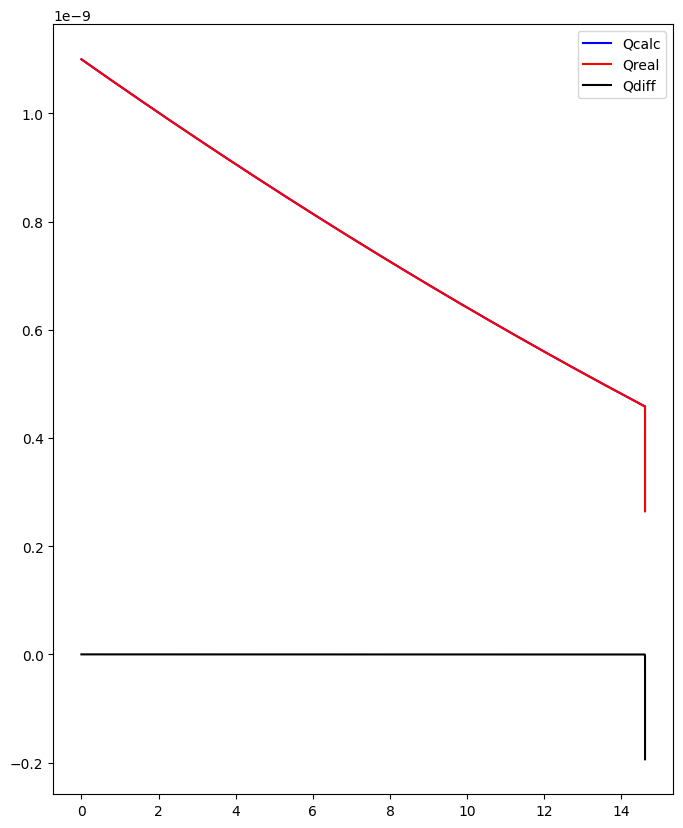

In [78]:
df = df_list[0]

plt.figure(figsize=(8, 10))
plt.plot(df["Duration_year"], df["Qcalc"], color="blue")
plt.plot(df["Duration_year"], df["Qreal"], color="red")
plt.plot(df["Duration_year"], df["Qdiff"], color="black")
plt.legend(["Qcalc", "Qreal", "Qdiff"])
plt.show()

1.1e-09 -> 14.61 Year
2.0999999999999998e-09 -> 7.65 Year
3.0999999999999996e-09 -> 5.19 Year
4.0999999999999995e-09 -> 3.92 Year
5.099999999999999e-09 -> 3.15 Year
6.099999999999999e-09 -> 2.64 Year
7.099999999999999e-09 -> 2.26 Year
8.1e-09 -> 1.98 Year
9.099999999999999e-09 -> 1.77 Year


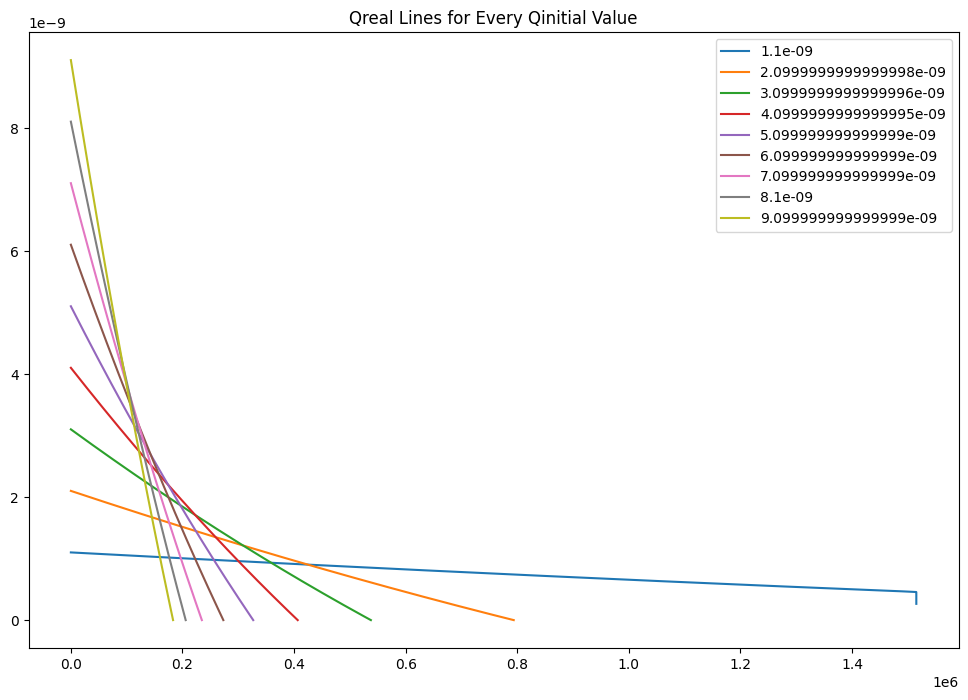

In [69]:
plt.figure(figsize=(12,8))

for index, Qinitial in enumerate(Qinitial_vals):
    duration_year = df_list[index]["Duration_year"].iloc[-1]
    plt.plot(range(len(Q_real_list[index])), Q_real_list[index])
    print(f"{Qinitial} -> {round(duration_year, 2)} Year")

plt.title("Qreal Lines for Every Qinitial Value")
plt.legend(Qinitial_vals, loc="upper right")
plt.show()

1.1e-09 -> 14.61 Year
2.0999999999999998e-09 -> 7.65 Year
3.0999999999999996e-09 -> 5.19 Year
4.0999999999999995e-09 -> 3.92 Year
5.099999999999999e-09 -> 3.15 Year
6.099999999999999e-09 -> 2.64 Year
7.099999999999999e-09 -> 2.26 Year
8.1e-09 -> 1.98 Year
9.099999999999999e-09 -> 1.77 Year


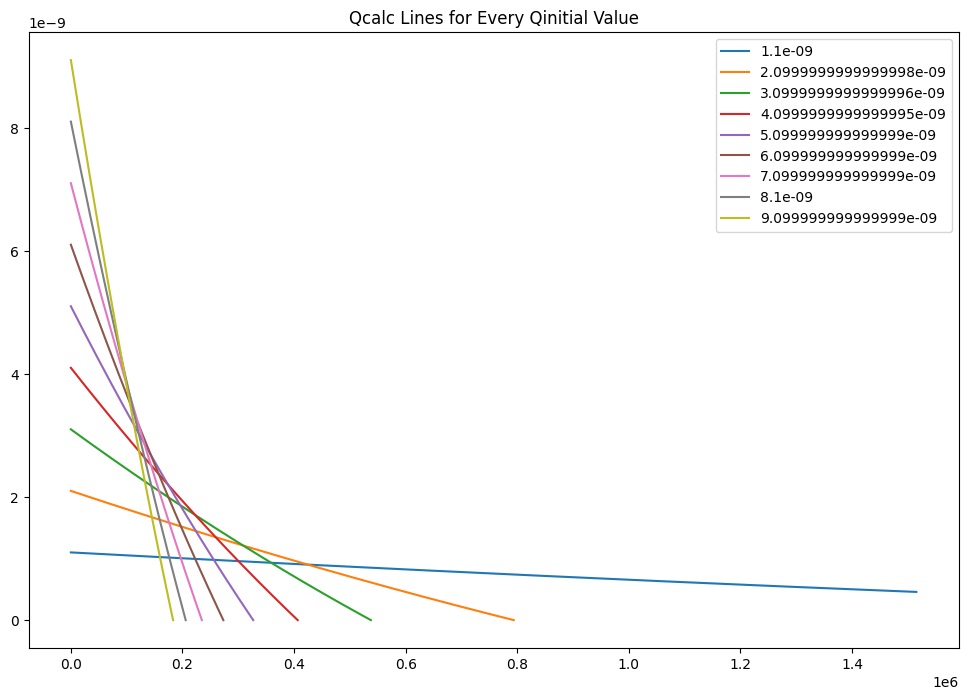

In [70]:
plt.figure(figsize=(12,8))

for index, Qinitial in enumerate(Qinitial_vals):
    duration_year = df_list[index]["Duration_year"].iloc[-1]
    plt.plot(range(len(Q_calc_list[index])), Q_calc_list[index])
    print(f"{Qinitial} -> {round(duration_year, 2)} Year")


plt.title("Qcalc Lines for Every Qinitial Value")
plt.legend(Qinitial_vals, loc="upper right")
plt.show()

1.1e-09 -> 14.61 Year
2.0999999999999998e-09 -> 7.65 Year
3.0999999999999996e-09 -> 5.19 Year
4.0999999999999995e-09 -> 3.92 Year
5.099999999999999e-09 -> 3.15 Year
6.099999999999999e-09 -> 2.64 Year
7.099999999999999e-09 -> 2.26 Year
8.1e-09 -> 1.98 Year
9.099999999999999e-09 -> 1.77 Year


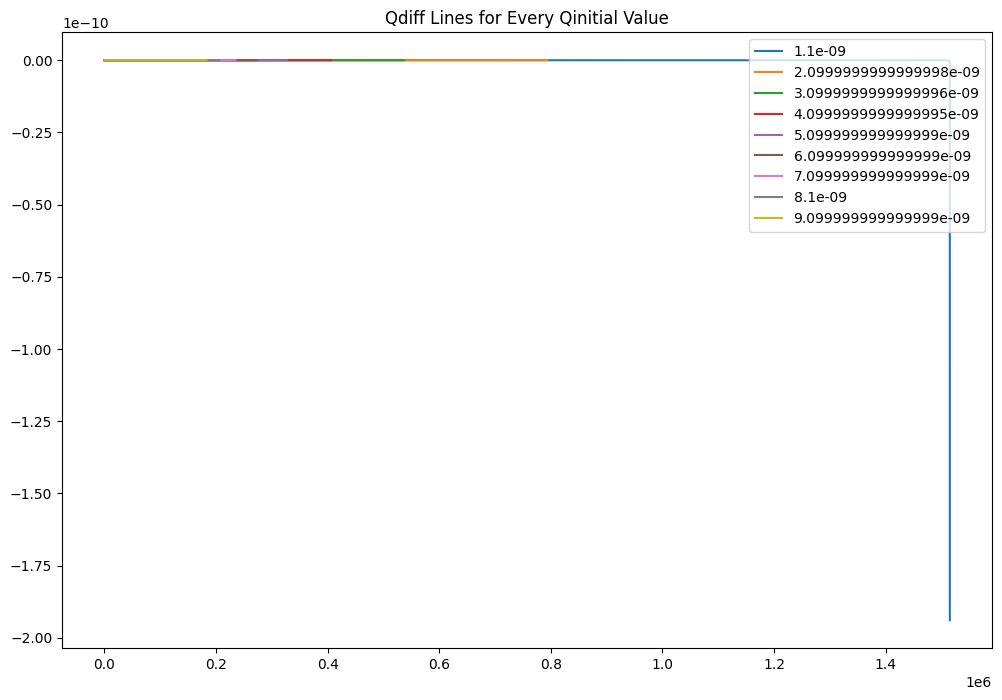

In [71]:
plt.figure(figsize=(12,8))

for index, Qinitial in enumerate(Qinitial_vals):
    duration_year = df_list[index]["Duration_year"].iloc[-1]
    plt.plot(range(len(Q_diff_list[index])), Q_diff_list[index])
    print(f"{Qinitial} -> {round(duration_year, 2)} Year")

plt.title("Qdiff Lines for Every Qinitial Value")
plt.legend(Qinitial_vals, loc="upper right")
plt.show()

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio
import plotly.offline as pyo

df = df_list[0]

trace_real = go.Scatter(x=df["Duration_year"], y=df["Qreal"], mode='lines', name='Qreal', line=dict(color='red'))
trace_calc = go.Scatter(x=df["Duration_year"], y=df["Qcalc"], mode='lines', name='Qcalc', line=dict(color='blue'))
trace_diff = go.Scatter(x=df["Duration_year"], y=df["Qdiff"], mode='lines', name='Qdiff', line=dict(color='black'))

layout = go.Layout(
    title='Plotly Plot',
    xaxis=dict(title='X-axis'),
    yaxis=dict(title='Y-axis', tickformat='.2e'),
    legend=dict(x=0, y=1)
)

fig = go.Figure(data=[trace_real, trace_calc, trace_diff], layout=layout)
pyo.iplot(fig)
pio.write_html(fig, file='plotly_plot.html')
